<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/Pulseq_zero_TSE_FAopt_SARtask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pypulseq==1.4.2
!pip install pulseqzero
!pip install MRzeroCore --no-deps &> /dev/null
!pip install pydisseqt
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.0/244.0 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.5/470.5 kB 10.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mrzerocore 0.3.13 requires torchkbnufft, which is not installed.


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import cm

import MRzeroCore as mr0
import pulseqzero
pp = pulseqzero.pp_impl

/usr/local/lib/python3.11/dist-packages/sigpy/config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
libcudnn.so.8: cannot open shared object file: No such file or directory
  warnings.warn(


(TSE_FAopt_SAR)=
# Pulseq-zero Demo
Pulseq-zero combines Pusleq and MR-zero and allows you to optimize a Pulseq sequence dirrectly.

For example, herein we want to optimize the variable refocusing flip angle train of a TSE sequence to achieve low SAR.



###First,###
we now need to define a TSE sequence as function with parameters we wish to optimize as arguments:

In [3]:
#@title Define TSE in PyPulseq
def tse_sequence(fov=200e-3, slice_thickness=8e-3, base_resolution=42,
                 TE_ms=5, TI_s=0, Ex_FA=90, Ref_FA=180, r_spoil=2,
                 PE_grad_on=True, RO_grad_on=True):
    """
    Generates a TSE sequence using PyPulseq.

    Args:
        system: PyPulseq system object.
        fov (float): Field of view in meters (default: 200e-3).
        slice_thickness (float): Slice thickness in meters (default: 8e-3).
        base_resolution (int): Base resolution for frequency and phase encoding (default: 42).
        TE_ms (float): Echo time in milliseconds (default: 5).
        TI_s (float): Inversion time in seconds (default: 0).
        Ex_FA (float): Excitation flip angle in degrees (default: 90).
        Ref_FA (float or array): Refocusing flip angle in degrees (default: 180).
        r_spoil (float): Spoil gradient factor (default: 2).
        PE_grad_on (bool): Enable/disable phase encoding gradients (default: True).
        RO_grad_on (bool): Enable/disable readout gradients (default: True).

    Returns:
        PyPulseq sequence object.
    """
    # Define resolution
    Nread = base_resolution  # frequency encoding steps/samples
    Nphase = base_resolution  # phase encoding steps/samples
    TE = TE_ms * 1e-3

    # %% S1. SETUP sys
    system = pp.Opts(
        max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
        rf_ringdown_time=20e-6, rf_dead_time=100e-6,
        adc_dead_time=20e-6, grad_raster_time=10e-6)

    seq = pp.Sequence(system)

    # Define rf events
    rf1, gz1, gzr1 = pp.make_sinc_pulse(
        flip_angle=Ex_FA * np.pi / 180, phase_offset=90 * np.pi / 180, duration=1e-3,
        slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
        system=system, return_gz=True)

    rf2, gz2, _ = pp.make_sinc_pulse(
        flip_angle=180*np.pi / 180, duration=1e-3,
        slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
        system=system, return_gz=True)

    dwell=50e-6*2

    G_flag=(int(RO_grad_on),int(PE_grad_on))  # gradient flag (read,PE), if (0,0) all gradients are 0, for (1,0) PE is off

    # Define other gradients and ADC events
    gx = pp.make_trapezoid(channel='x', rise_time = 0.5*dwell, flat_area=Nread / fov*G_flag[0], flat_time=Nread*dwell, system=system)
    adc = pp.make_adc(num_samples=Nread, duration=Nread*dwell, phase_offset=90 * np.pi / 180, delay=0*gx.rise_time, system=system)
    gx_pre0 = pp.make_trapezoid(channel='x', area=+((1.0 + r_spoil) * gx.area / 2) , duration=1.5e-3, system=system)
    gx_prewinder = pp.make_trapezoid(channel='x', area=+(r_spoil * gx.area / 2), duration=1e-3, system=system)
    gp = pp.make_trapezoid(channel='y', area=0 / fov, duration=1e-3, system=system)
    rf_prep = pp.make_block_pulse(flip_angle=180 * np.pi / 180, duration=1e-3, system=system)


    # FLAIR
    if TI_s>0:
      seq.add_block(rf_prep)
      seq.add_block(pp.make_delay(TI_s))
      seq.add_block(gx_pre0)

    seq.add_block(rf1,gz1)
    seq.add_block(gx_pre0,gzr1)

    # the minimal TE is given by one full period form ref pulse to ref pulse, thus gz2+gx+2*gp
    minTE2=(pp.calc_duration(gz2) +pp.calc_duration(gx) + 2*pp.calc_duration(gp))/2

    minTE2=np.round(minTE2/10e-5)*10e-5


    # to realize longer TE,  we introduce a TEdelay that is added before and afetr the encoding period
    TEd=np.round(max(0, (TE/2-minTE2))/10e-5)*10e-5  # round to raster time

    if TEd==0:
      print('echo time set to minTE [ms]', 2*(minTE2 +TEd)*1000)
    else:
      print(' TE [ms]', 2*(minTE2 +TEd)*1000)


    # last timing step is to add TE/2 also between excitation and first ref pulse
    # from pulse top to pulse top we have already played out one full rf and gx_pre0, thus we substract these from TE/2
    seq.add_block(pp.make_delay((minTE2 +TEd ) - pp.calc_duration(gz1)-pp.calc_duration(gx_pre0)))

    encoding = []

    for ii in range(-Nphase // 2, Nphase // 2):  # e.g. -64:63
        gp  = pp.make_trapezoid(channel='y', area=+ii / fov*G_flag[1], duration=1e-3, system=system)
        gp_ = pp.make_trapezoid(channel='y', area=-ii / fov*G_flag[1], duration=1e-3, system=system)
        encoding.append(ii)

        # Try to index into a variable FA array, if it fails treat it as number
        try:
            flip_angle = Ref_FA[ii] * torch.pi / 180
        except:
            flip_angle = Ref_FA * torch.pi / 180
        rf2, gz2, _ = pp.make_sinc_pulse(flip_angle=flip_angle, duration=1e-3,slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,system=system, return_gz=True)

        seq.add_block(rf2,gz2)
        seq.add_block(pp.make_delay(TEd)) # TE delay
        seq.add_block(gx_prewinder, gp)
        seq.add_block(adc, gx)
        seq.add_block(gx_prewinder, gp_)
        seq.add_block(pp.make_delay(TEd)) # TE delay

    # %% S2. CHECK, PLOT and WRITE the sequence  as .seq
    # Check whether the timing of the sequence is correct
    ok, error_report = seq.check_timing()
    if ok:
        print('Timing check passed successfully')
    else:
        print('Timing check failed. Error listing follows:')
        [print(e) for e in error_report]

    return seq, encoding

In [4]:
# @title image reconstruction via FFT

def reconstruction(signal, encoding, Nread, Nphase):
  # reconstruct image
  kspace = torch.reshape((signal), (Nread, Nphase)).clone().t()
  encoding = np.stack(encoding)
  ipermvec = np.argsort(encoding)
  kspace=kspace[:,ipermvec]

  # fftshift FFT fftshift
  spectrum = torch.fft.fftshift(kspace)
  space = torch.fft.fft2(spectrum)
  space = torch.fft.ifftshift(space)

  return space

In [9]:
# @title ploting functions for optimization steps and results

def plot_results_images(target, result, finished=False, colorbars=False):

  # show target, initial and optimized image on common colorscale
  vmin = min(target.min(), result.min())
  vmax = max(target.max(), result.max())

  plt.subplot(121)
  plt.title("optimizer target")
  plt.axis('off')
  mr0.util.imshow(target, vmin=vmin, vmax=vmax, cmap=cm.gray)
  if colorbars: plt.colorbar(cmap='gray')

  plt.subplot(122)
  if finished: plt.title("optimizer result")
  else: plt.title("optimizer step")
  plt.axis('off')
  mr0.util.imshow(result, vmin=vmin, vmax=vmax, cmap=cm.gray)
  if colorbars: plt.colorbar(cmap='gray')

  plt.show()

def plot_optimizer_history(loss_hist, param_hist, rSAR_hist, finished=False):
    #plt.figure(figsize=(12, 4))

    plt.subplot(121)
    plt.title("Loss and rSAR")
    plt.xlabel("itertation")
    plt.plot([l / loss_hist[0] for l in loss_hist], label="loss")
    plt.plot(rSAR_hist, label="rSAR")
    if finished:
      plt.plot([np.argmin(loss_hist), np.argmin(loss_hist)], [[l / loss_hist[0] for l in loss_hist][np.argmin(loss_hist)], rSAR_hist[np.argmin(loss_hist)]], "rx", label="optimum")

    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.xlabel("repetition")
    plt.ylabel("FA")
    plt.title("Optim. param")
    if finished: plt.plot(np.array(param_hist).T)
    else: plt.plot(np.array(param_hist[-2:]).T) # only plot current and last flip angle configuration
    plt.gca().yaxis.tick_right()
    plt.grid()

    plt.show()

def plot_optimized_flipangles(fa_optimized):
  plt.plot(fa_optimized, "o--")
  plt.xlabel("repetition")
  plt.ylabel("FA [deg]")
  plt.title("Optimized refocusing flip angles")
  plt.gca().yaxis.tick_right()
  plt.grid()
  plt.show()

In [10]:
# @title Setup spin system

obj_p = mr0.util.load_phantom([96,96])


echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully


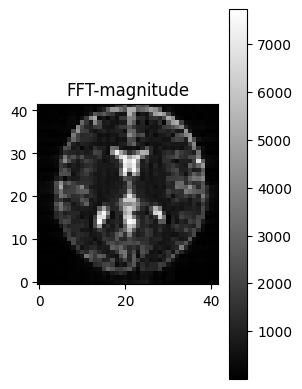

In [11]:
# @title Generate optimization target

base_resolution=42
Ex_FA=90    # excitation flip angle
Ref_FA_target= torch.full((base_resolution,), 180)  # refocusing flip angle

with pulseqzero.mr0_mode():
  seq, encoding = tse_sequence(base_resolution=base_resolution, Ex_FA=Ex_FA, Ref_FA=Ref_FA_target)

  seq0 = seq.to_mr0()
  signal,_ = mr0.util.simulate(seq0,obj_p,accuracy=1e-4)

# reconstruct image
space = reconstruction(signal, encoding, base_resolution, base_resolution)

# plot result
plt.subplot(121)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()), cmap=cm.gray)
plt.colorbar()

# store target for optimization
target = torch.abs(space)

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
1 / 100: loss=0.15000000596046448, rSAR=1.0, Ref_FA=[180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180.
 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180.
 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180.]


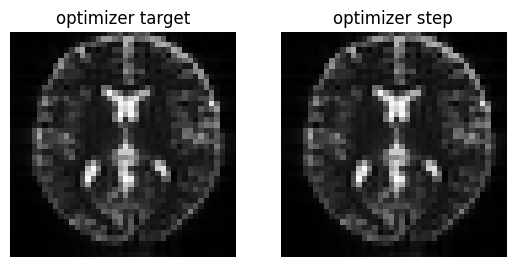

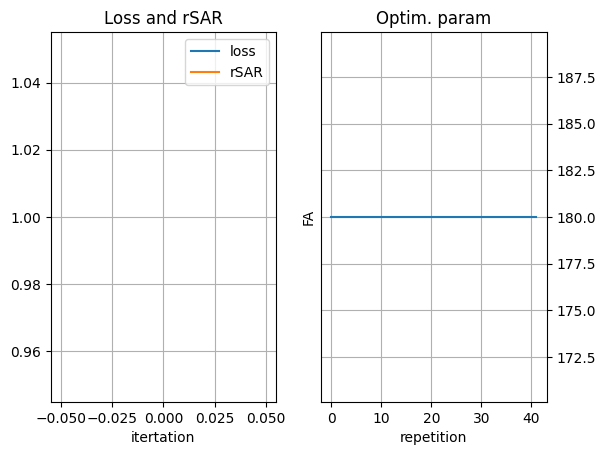

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
2 / 100: loss=0.14181561768054962, rSAR=0.9452298283576965, Ref_FA=[175.00127 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127
 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127
 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127
 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127
 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127
 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127 175.00127]


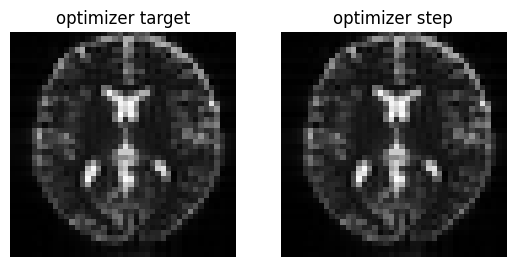

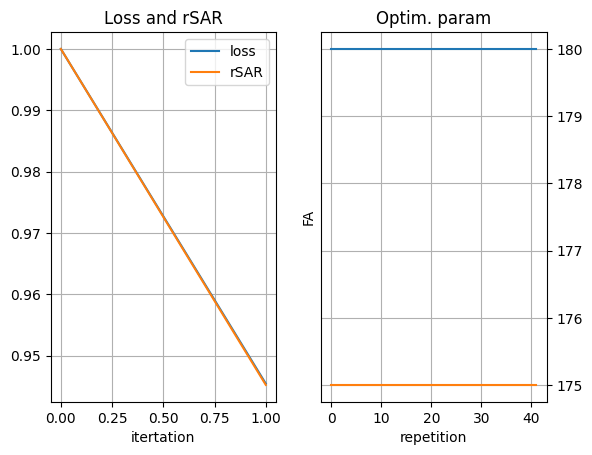

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
3 / 100: loss=0.13390499353408813, rSAR=0.8920814990997314, Ref_FA=[170.0205  170.00363 170.00792 170.00731 170.00742 170.00784 170.00731
 170.00687 170.00691 170.00693 170.00691 170.00691 170.00668 170.007
 170.00658 170.00702 170.00668 170.00685 170.00674 170.00676 170.00676
 170.03532 169.99783 170.02077 170.00296 170.00954 170.01053 170.0032
 170.01826 169.9999  170.02501 169.9982  170.03012 169.99738 170.03291
 169.99706 170.03358 169.9971  170.03271 169.99745 170.02985 169.99767]


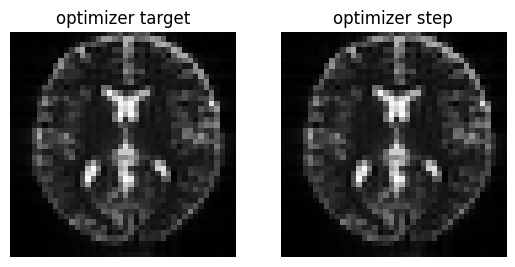

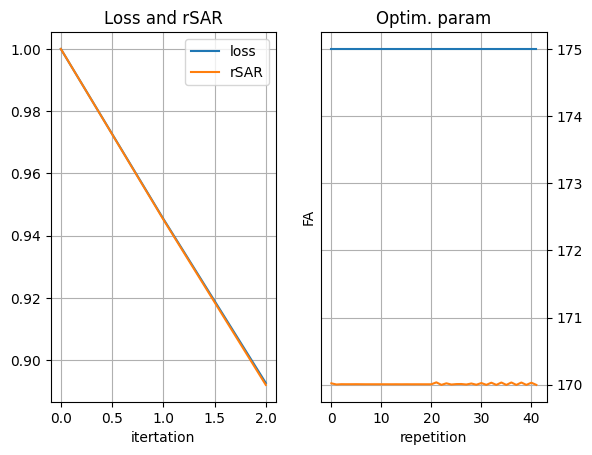

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
4 / 100: loss=0.12627844512462616, rSAR=0.8405940532684326, Ref_FA=[165.04233 165.0195  165.01907 165.02652 165.01974 165.02292 165.01897
 165.02066 165.01976 165.01993 165.01988 165.01984 165.01944 165.02
 165.01907 165.02008 165.01944 165.01962 165.0195  165.01938 165.01942
 165.19148 164.98222 165.11412 164.99335 165.0505  165.01688 165.01582
 165.0457  164.99904 165.07195 164.9914  165.08965 164.98889 165.0937
 164.99031 165.08571 164.9941  165.07445 165.00185 165.06294 165.00475]


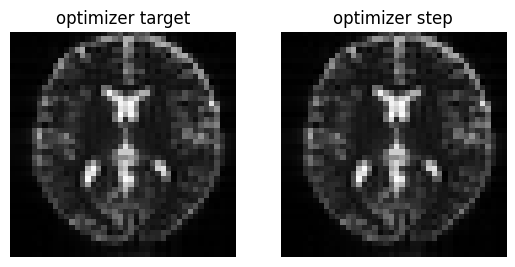

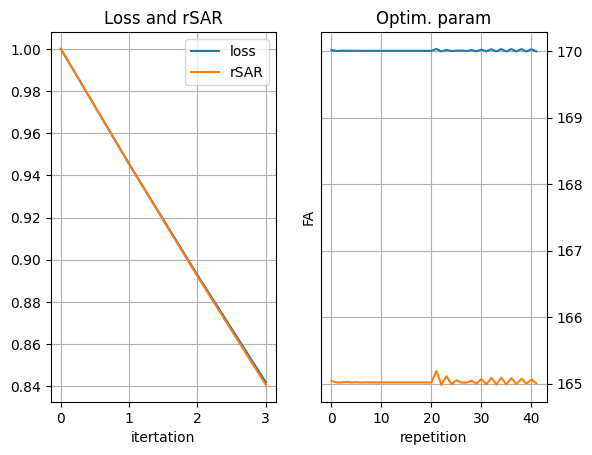

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
5 / 100: loss=0.11894423514604568, rSAR=0.7908890247344971, Ref_FA=[160.04872 160.07237 160.03221 160.07404 160.0365  160.0511  160.03967
 160.04529 160.04425 160.0425  160.04507 160.04155 160.04465 160.04193
 160.0435  160.0425  160.04343 160.0426  160.04259 160.04239 160.04228
 160.68082 159.95274 160.38184 159.96725 160.14542 160.024   160.03264
 160.11014 159.98744 160.18867 159.97139 160.22322 159.9701  160.20256
 159.98456 160.14755 160.01279 160.1025  160.0527  160.08168 160.07326]


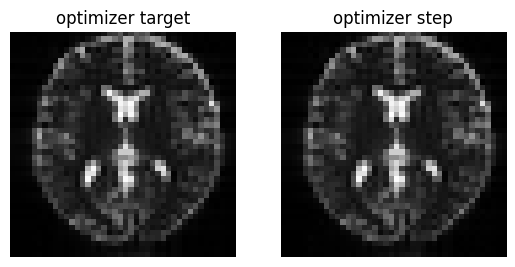

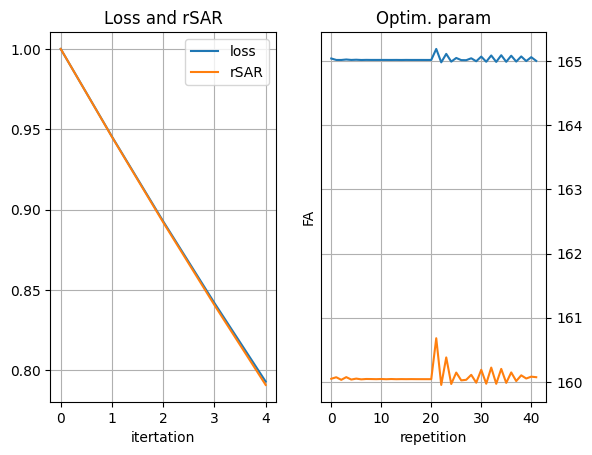

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
6 / 100: loss=0.11175167560577393, rSAR=0.7431010007858276, Ref_FA=[155.02878 155.15508 155.06467 155.13698 155.06526 155.09396 155.07559
 155.0809  155.08626 155.07607 155.087   155.07428 155.08624 155.0759
 155.0829  155.0783  155.08127 155.07973 155.07869 155.07936 155.07841
 156.62393 154.9022  155.8288  154.93256 155.25406 155.0797  155.02473
 155.32281 154.95018 155.52371 154.92789 155.54759 154.93105 155.40794
 154.97626 155.2203  155.07402 155.10774 155.20082 155.07239 155.30455]


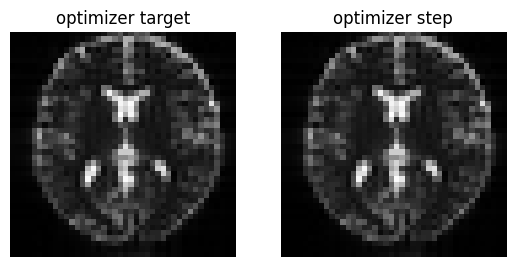

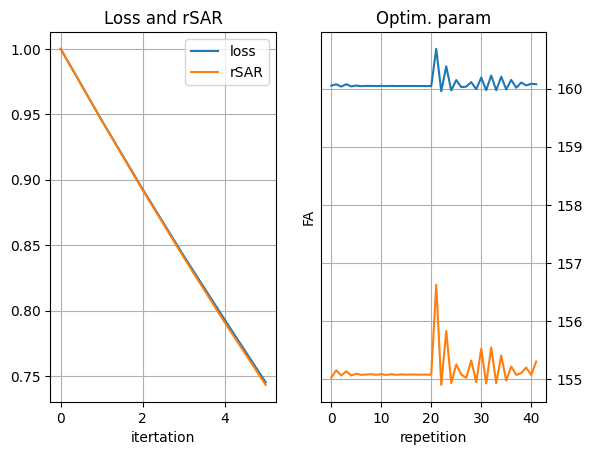

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
7 / 100: loss=0.10500513017177582, rSAR=0.6969452500343323, Ref_FA=[149.98242 150.24777 150.10823 150.22118 150.10446 150.16649 150.11853
 150.14754 150.13718 150.13486 150.14261 150.1263  150.1458  150.12549
 150.14182 150.12915 150.13834 150.13286 150.1325  150.13278 150.13165
 152.4017  149.9406  151.15662 150.01279 150.32402 150.20564 150.03943
 150.51935 149.98143 150.77884 149.97343 150.78864 149.97116 150.57104
 150.0309  150.28183 150.20392 150.10085 150.45511 150.03798 150.68611]


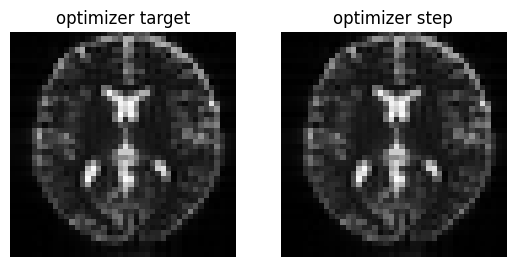

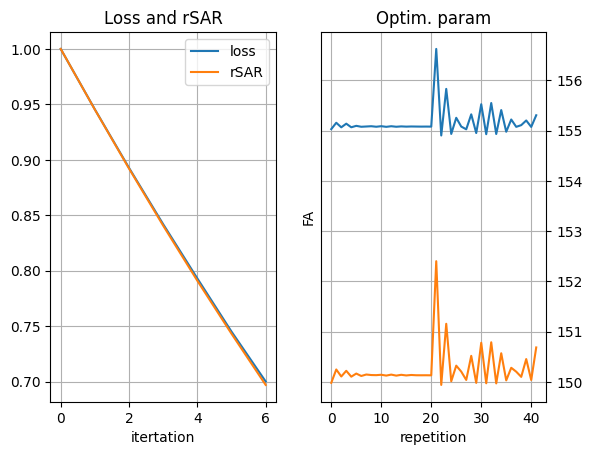

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
8 / 100: loss=0.0986156165599823, rSAR=0.6525260210037231, Ref_FA=[144.90517 145.35449 145.16629 145.34093 145.15292 145.28273 145.16647
 145.25743 145.19818 145.22427 145.21622 145.19998 145.22945 145.19292
 145.22498 145.1988  145.21771 145.20659 145.20662 145.20691 145.20522
 148.17572 145.03012 146.42624 145.19644 145.37463 145.40414 145.08835
 145.71109 145.08888 145.98335 145.09933 145.99222 145.0664  145.74564
 145.12451 145.36815 145.39261 145.09286 145.85052 144.97949 146.31044]


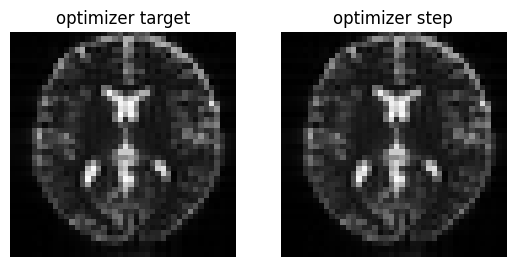

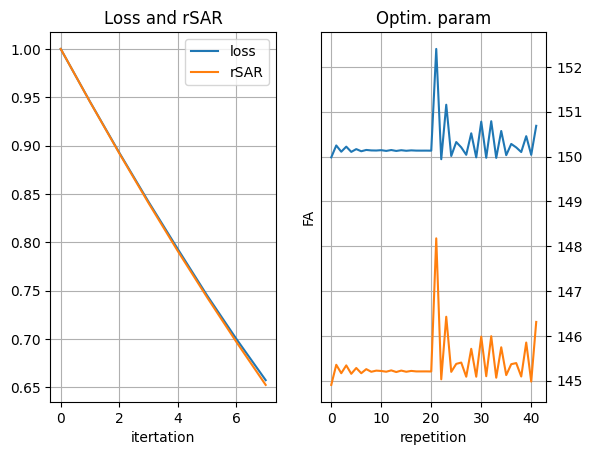

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
9 / 100: loss=0.0926312506198883, rSAR=0.6099593043327332, Ref_FA=[139.79594 140.48228 140.24031 140.5217  140.20497 140.46428 140.21658
 140.42355 140.27396 140.34802 140.31404 140.29822 140.34253 140.28354
 140.3342  140.29381 140.32169 140.30592 140.3043  140.30548 140.30286
 144.22266 140.12434 141.71193 140.45949 140.43425 140.66104 140.19951
 140.89758 140.29121 141.15404 140.30829 141.18245 140.21628 140.96283
 140.25493 140.51674 140.62485 140.11462 141.38277 139.90843 142.26585]


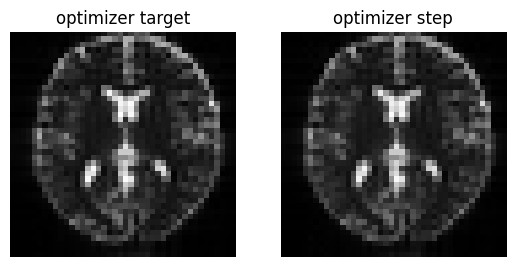

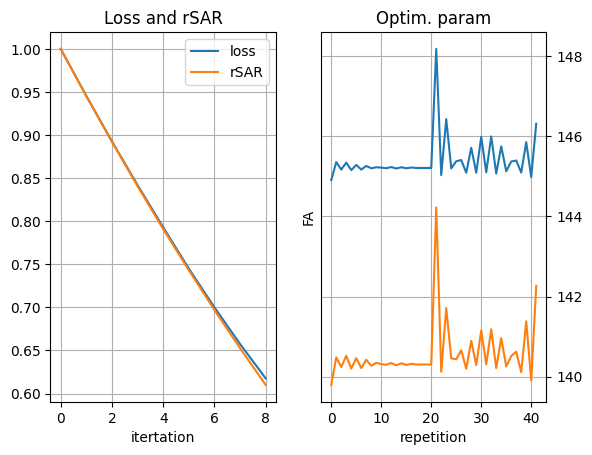

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
10 / 100: loss=0.0870581567287445, rSAR=0.5694003701210022, Ref_FA=[134.65303 135.64615 135.32954 135.7822  135.26414 135.7254  135.27187
 135.6527  135.37035 135.51154 135.44026 135.4266  135.48827 135.40465
 135.47029 135.42038 135.45511 135.43398 135.43022 135.43219 135.42798
 140.98888 135.19124 137.08624 135.79546 135.52783 135.96974 135.40536
 136.08644 135.59778 136.31178 135.6022  136.36133 135.45265 136.21304
 135.44434 135.77435 135.87263 135.23543 137.02457 134.83994 138.68721]


KeyboardInterrupt: 

In [12]:
# @title Perform optimization

# sequence parametes
base_resolution=42
Ex_FA = 90    # excitation flip angle
Ref_FA = torch.full((base_resolution,), 180.0, requires_grad=True)  # refocusing flip angles

# initalize optimizer
iterations = 100
params = [{"params": Ref_FA, "lr": 5.0}]  # adjust learning rate as needed
optimizer = torch.optim.Adam(params)

lambda_SAR = 0.15
lambda_image = 1-lambda_SAR

loss_hist = []
rSAR_hist = []
Ref_FA_hist = []

# optimization loop
for i in range(iterations):

    optimizer.zero_grad()

    # ====
    # simulate
    # ====

    with pulseqzero.mr0_mode():
      seq, encoding = tse_sequence(base_resolution=base_resolution, Ex_FA=Ex_FA, Ref_FA=Ref_FA)

      seq0 = seq.to_mr0()

      if i%5 == 0:
        graph = mr0.compute_graph(seq0, obj_p.build(), 100000, 1e-4)

      signal = mr0.execute_graph(graph, seq0, obj_p.build(), 1e-4, 1e-4)
    # reconstruct image
    space = reconstruction(signal, encoding, base_resolution, base_resolution)
    image = torch.abs(space) # current optimizer step image


    # ====
    # loss computation
    # ====

    MSE_image = ((image - target)**2).mean()/((target**2).mean())  # MSE of images
    rSAR = torch.sum(Ref_FA**2)/torch.sum(Ref_FA_target**2)     # relative SAR

    loss = lambda_SAR * rSAR + lambda_image * MSE_image

    print(f"{i+1} / {iterations}: loss={loss.item()}, rSAR={rSAR}, Ref_FA={Ref_FA.detach().numpy()}")

    loss_hist.append(loss.item())
    rSAR_hist.append(rSAR.item())
    Ref_FA_hist.append(Ref_FA.detach().numpy().copy())

    # ====
    # perform optimizer step
    # ====

    loss.backward()
    optimizer.step()

    # plot images
    plot_results_images(target, image)

    # optimization timeline
    plot_optimizer_history(loss_hist, Ref_FA_hist, rSAR_hist)

echo time set to minTE [ms] tensor(7.4000, dtype=torch.float64)
Timing check passed successfully
Calculating repetition 43 / 43 - done
Optimized rSNR: 0.5694003701210022
Optimized Ref_FA: [134.65303 135.64615 135.32954 135.7822  135.26414 135.7254  135.27187
 135.6527  135.37035 135.51154 135.44026 135.4266  135.48827 135.40465
 135.47029 135.42038 135.45511 135.43398 135.43022 135.43219 135.42798
 140.98888 135.19124 137.08624 135.79546 135.52783 135.96974 135.40536
 136.08644 135.59778 136.31178 135.6022  136.36133 135.45265 136.21304
 135.44434 135.77435 135.87263 135.23543 137.02457 134.83994 138.68721]


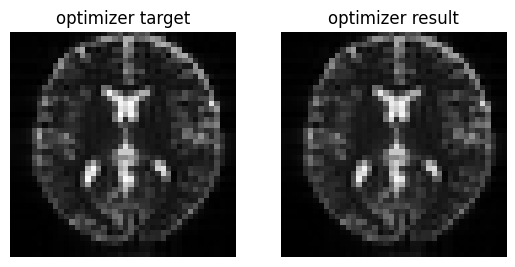

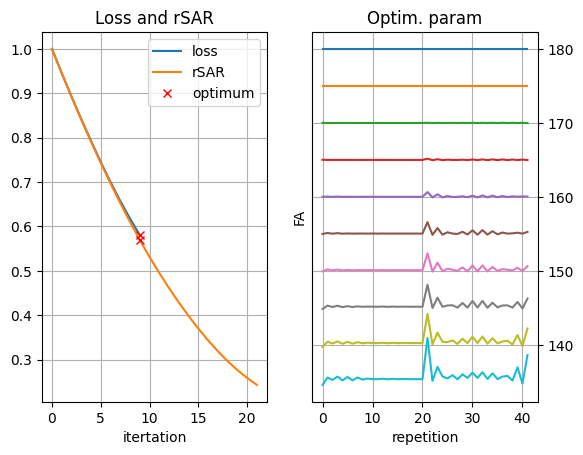

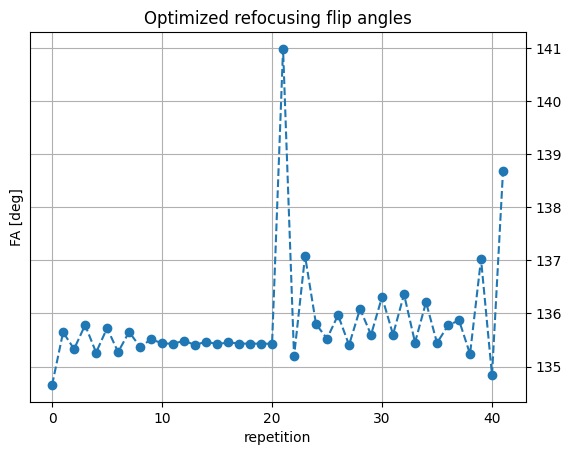

In [13]:
# @title Evaluate optimization result


# simute optimizer result: optimal flip angle configuration
with pulseqzero.mr0_mode():
  seq, encoding = tse_sequence(base_resolution=base_resolution, Ex_FA=Ex_FA, Ref_FA=Ref_FA_hist[np.argmin(loss_hist)])
  seq0 = seq.to_mr0()
  graph = mr0.compute_graph(seq0, obj_p.build(), 100000, 1e-8)
  signal = mr0.execute_graph(graph, seq0, obj_p.build(), 1e-8, 1e-8)  # high accuracy to check if more states are neccesary

  # reconstruct image
  space = reconstruction(signal, encoding, base_resolution, base_resolution)
  result = torch.abs(space) # current optiumizer step image

# ====
# plot results
# ====

print(f"Optimized rSNR: {rSNR_hist[np.argmin(loss_hist)]}")
print(f"Optimized Ref_FA: {Ref_FA_hist[np.argmin(loss_hist)]}")

# images
plot_results_images(target, result, finished=True)

# optimization timeline
plot_optimizer_history(loss_hist, Ref_FA_hist, rSNR_hist, finished=True)

# optimized flip angle configuration
plot_optimized_flipangles(Ref_FA_hist[np.argmin(loss_hist)])